In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore') 

In [6]:
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target

print(df.shape)
df.head()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [17]:
# Basic Statistics
print('Dataset Info :')
print(df.info())

print('\nSummary Statistics : \n', df.describe())

print('\nMissing Values : ', df.isnull().sum())

print('\Target (MedHouseVal) Statistics : \n', df['MedHouseVal'].describe())

Dataset Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Summary Statistics : 
              MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000

**Visualizations**

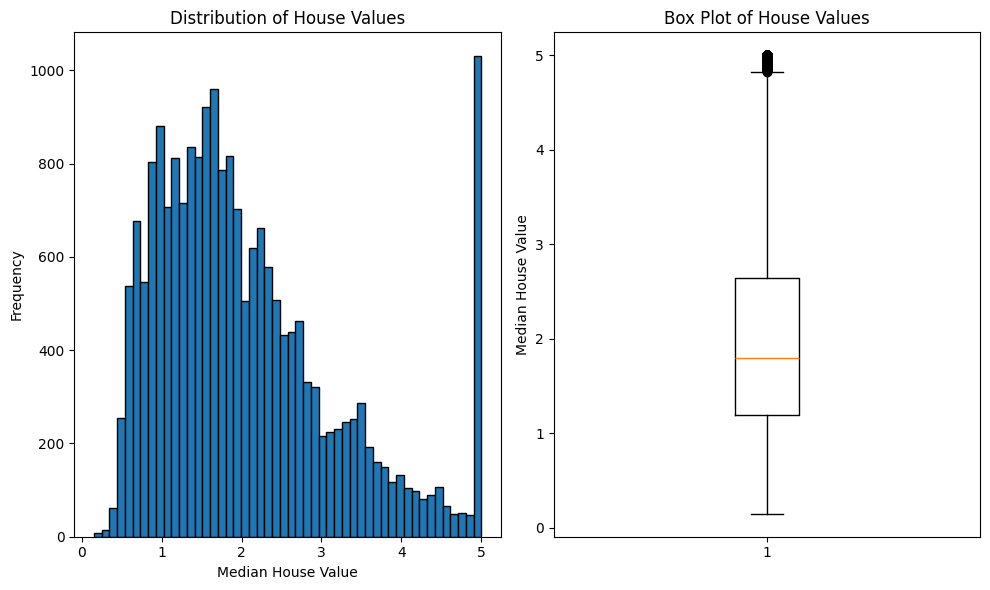

In [18]:
# Distribution of target variable
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(df['MedHouseVal'], bins=50, edgecolor='black')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.title('Distribution of House Values')

plt.subplot(1, 2, 2)
plt.boxplot(df['MedHouseVal'])
plt.ylabel('Median House Value')
plt.title('Box Plot of House Values')

plt.tight_layout()
plt.show()

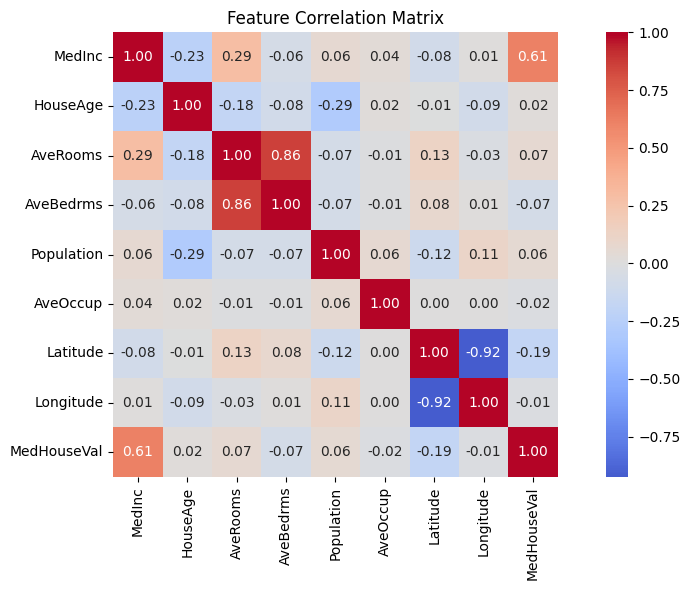

Highly correlated feature pairs (>0.8):
  AveRooms - AveBedrms: 0.861
  Latitude - Longitude: -0.923


In [36]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
correlation_metrix = df.corr()
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

high_corr_pairs = []
for i in range(len(correlation_metrix.columns)):
    for j in range(i+1, len(correlation_metrix.columns)):
        if abs(correlation_metrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_metrix.columns[i],
                correlation_metrix.columns[j],
                correlation_metrix.iloc[i, j]
            ))

print("Highly correlated feature pairs (>0.8):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"  {feat1} - {feat2}: {corr:.3f}")

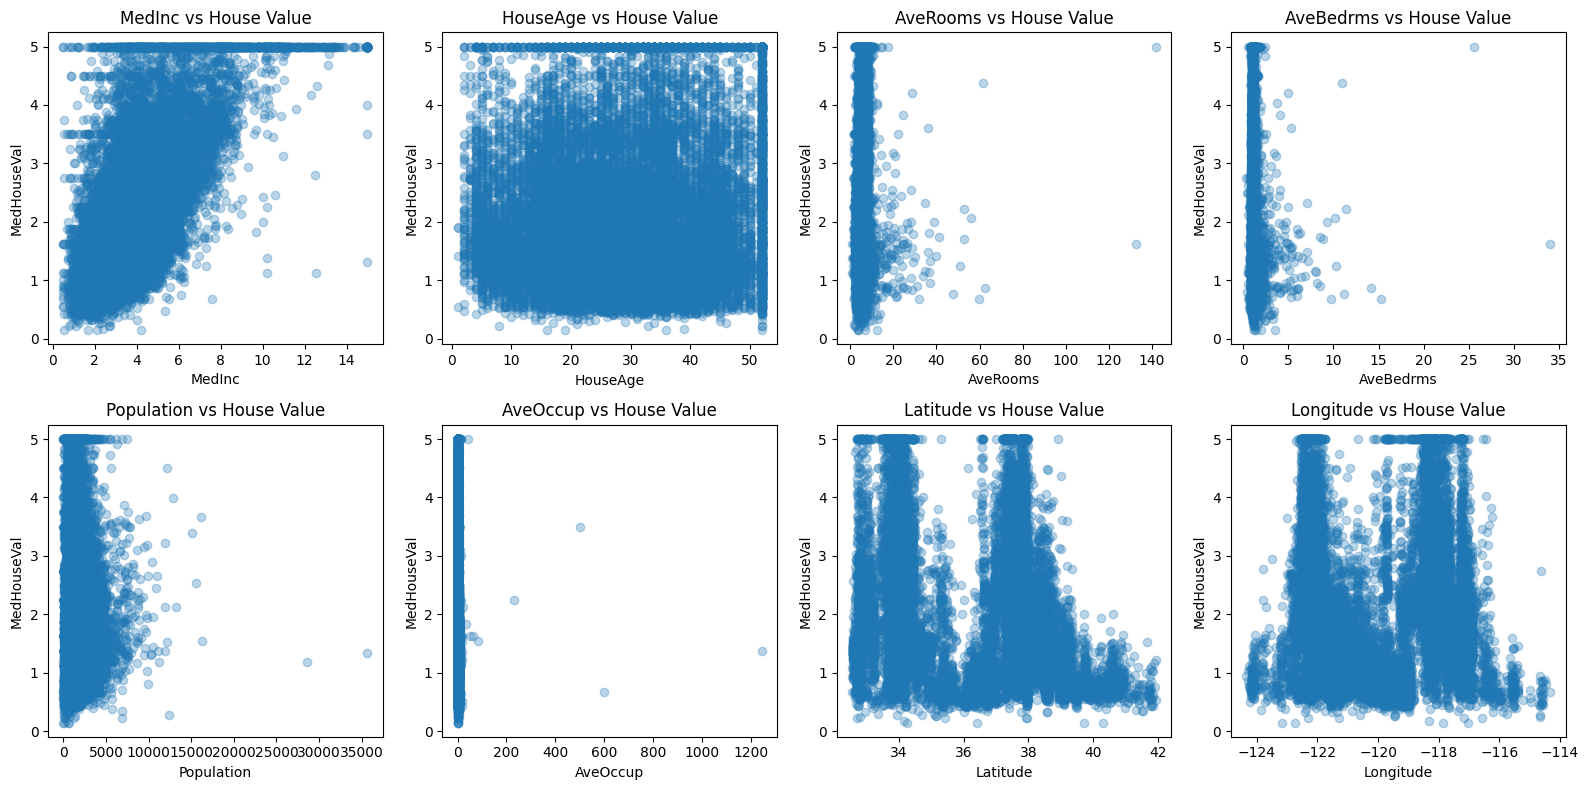

In [20]:
# Scatter plots of features vs target
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for idx, feature in enumerate(housing.feature_names):
    axes[idx].scatter(df[feature], df['MedHouseVal'], alpha=0.3)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('MedHouseVal')
    axes[idx].set_title(f'{feature} vs House Value')

plt.tight_layout()
plt.show()

**Handle Outliers**

In [22]:
def remove_outlier_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q1 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Original shape: {df.shape}")
df_clean = remove_outlier_iqr(df, 'MedHouseVal')
print(f"After removing outliers: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} outliers ({100*(len(df) - len(df_clean))/len(df):.1f}%)")

Original shape: (20640, 9)
After removing outliers: (17688, 9)
Removed 2952 outliers (14.3%)


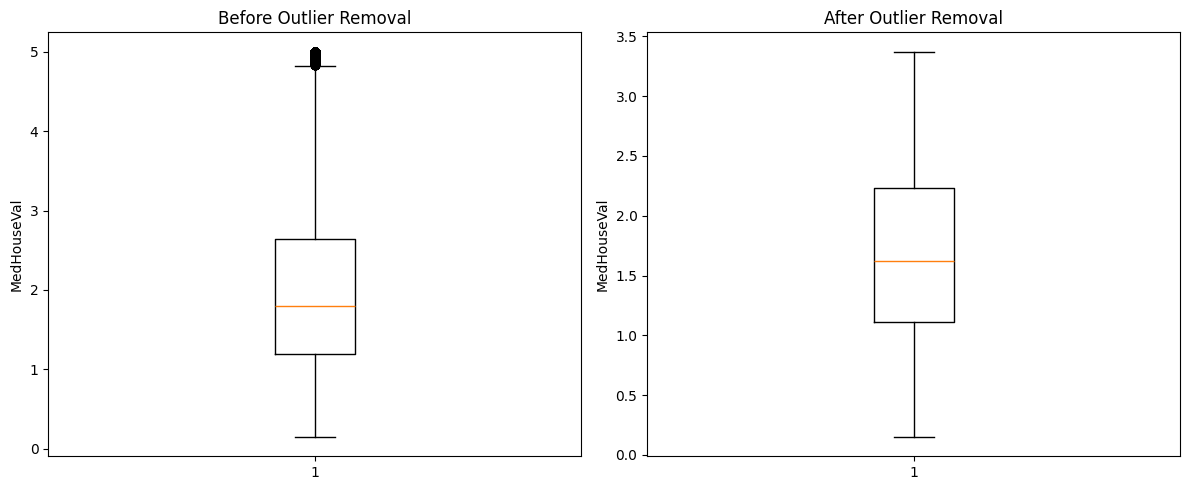

In [24]:
# Visualize before and after
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].boxplot(df['MedHouseVal'])
axes[0].set_title('Before Outlier Removal')
axes[0].set_ylabel('MedHouseVal')

axes[1].boxplot(df_clean['MedHouseVal'])
axes[1].set_title('After Outlier Removal')
axes[1].set_ylabel('MedHouseVal')

plt.tight_layout()
plt.show()

df = df_clean

In [25]:
x = df[housing.feature_names]
y = df['MedHouseVal']

print(f"Features shape: {x.shape}")
print(f"Target shape: {y.shape}")

Features shape: (17688, 8)
Target shape: (17688,)


**Feature Engineering**

In [35]:
# Check Multicollinearity
def calculate_vif(x):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = x.columns
    vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif_df = calculate_vif(x)
print("Variance Inflation Factors: \n", vif_df)

high_vif = vif_df[vif_df["VIF"] > 10]
if len(high_vif) > 0:
    print(f"\nWarning: {len(high_vif)} features have high VIF (>10)")
    print("Consider using regularization (Ridge/Lasso)")

Variance Inflation Factors: 
       Feature         VIF
7   Longitude  649.760751
6    Latitude  554.270809
2    AveRooms   50.342193
3   AveBedrms   46.374027
0      MedInc   15.512390
1    HouseAge    7.403225
4  Population    2.973462
5    AveOccup    1.097999

Consider using regularization (Ridge/Lasso)


In [ ]:
# Highly correlated feature pairs (>0.8):
#   AveRooms - AveBedrms: 0.861
#   Latitude - Longitude: -0.923

In [ ]:
x['BedrmsPerRoom'] = x['AveBedrms'] / x['AveRooms']


In [38]:
vif_df = calculate_vif(x)
print("Variance Inflation Factors: \n", vif_df)

high_vif = vif_df[vif_df["VIF"] > 10]
if len(high_vif) > 0:
    print(f"\nWarning: {len(high_vif)} features have high VIF (>10)")
    print("Consider using regularization (Ridge/Lasso)")

Variance Inflation Factors: 
          Feature         VIF
7      Longitude  862.525822
6       Latitude  579.871212
2       AveRooms  133.019446
3      AveBedrms  115.667273
8  BedrmsPerRoom   75.691811
0         MedInc   15.601910
1       HouseAge    7.435687
4     Population    2.973515
5       AveOccup    1.098150

Consider using regularization (Ridge/Lasso)
